## Homework #2 – Numeric Computing
### Problem 2(b)
### Tejas Harishchandra Acharya
### 11/08/2025

In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import re
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
# Constants
MICKEY_FILENAME = "../../data/input/mickey.csv"
K = 3
PATTERN = "^#"
CLASS_DICT = {'Head':1, 'Ear_left':0, 'Ear_right':2}
COLOR_DICT = {'Head':'b', 'Ear_left':'r', 'Ear_right':'g'}
KMEANS_CENTROIDS_FILENAME = "../../data/output/kmeans_centroids.txt"
KMEANS_LABELS_FILENAME = "../../data/output/kmeans_labels.txt"

MAX_ITERATIONS = 100
CONVERGENCE_CRITERION = 10E-6

In [3]:
def update_gamma_k(x, weight, mu, sigma, k):
    K, D = mu.shape
    num = weight[k] * get_gauss_pdf_k(x, mu[k], sigma[k], D)
    den = 0
    for j in range(K):
        den += weight[j] * get_gauss_pdf_k(x, mu[j], sigma[j], D)
    return num / den

In [4]:
def update_mu_k(X, gamma_k):
    N, _ = X.shape
    num = 0
    den = 0
    for n in range(N):
        num += gamma_k[n] * X[n]
        den += gamma_k[n]
    return num /den

In [5]:
def update_sigma_k(X, gamma_k, mu_k):
    N, D = X.shape
    num = np.zeros((D, D))
    den = 0
    for n in range(N):
        diff = (X[n] - mu_k).reshape(-1, 1)
        num += gamma_k[n] * (diff @ diff.T)
        den += gamma_k[n]
    return num / den

In [6]:
def update_weight_k(gamma_k, N):
    total = 0
    for n in range(N):
        total += gamma_k[n]
    return total / N

In [7]:
def get_gauss_pdf_k(x, mu_k, sigma_k, d):
    diff = (x - mu_k).reshape(-1, 1)
    num = math.exp(-0.5 * (diff.T @ (np.linalg.pinv(sigma_k)) @ diff))
    den = math.sqrt(math.pow(2 * math.pi, d) * np.linalg.det(sigma_k))
    return num / den

In [8]:
def get_log_likelihood(X, mu, sigma, weights):
    ll = 0
    N, _ = X.shape
    K, D = mu.shape
    for n in range(N):
        inner_sum = 0
        for k in range(K):
            inner_sum += weights[k] * get_gauss_pdf_k(X[n], mu[k], sigma[k], D)
        ll += math.log(inner_sum)
    return ll

In [9]:
mickey_X = []
mickey_label = []

with open(MICKEY_FILENAME, "r") as file:
    for i in csv.reader(file):
        if not re.search(PATTERN, i[0]):
            x1, x2, label = i[0].split()
            mickey_X.append([float(x1), float(x2)])
            mickey_label.append(label)
            
mickey_X = np.array(mickey_X)
mickey_label = np.array(mickey_label)

mickey_X_true_head = mickey_X[mickey_label == "Head"]
mickey_X_true_ear_left = mickey_X[mickey_label == "Ear_left"]
mickey_X_true_ear_right = mickey_X[mickey_label == "Ear_right"]

mickey_Y = list(map(lambda x: CLASS_DICT[x], mickey_label))
mickey_Y = np.array(mickey_Y)

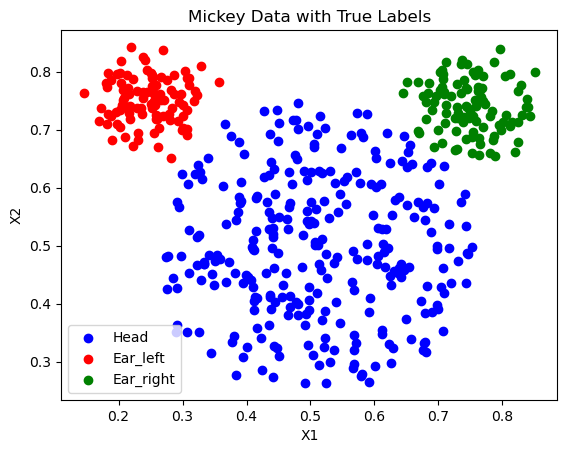

In [10]:
plt.figure()
plt.scatter(mickey_X_true_head[:, 0], mickey_X_true_head[:, 1], c='b')
plt.scatter(mickey_X_true_ear_left[:, 0], mickey_X_true_ear_left[:, 1], c='r')
plt.scatter(mickey_X_true_ear_right[:, 0], mickey_X_true_ear_right[:, 1], c='g')
plt.legend(["Head", "Ear_left", "Ear_right"])
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Mickey Data with True Labels")
plt.show()

In [11]:
N, D = mickey_X.shape

gamma = np.zeros((N, K))
mu = np.random.rand(K, D)
sigma = np.random.rand(K, D, D)
weights = np.random.rand(K)

In [12]:
# Initial Updation
kmeans_label = np.loadtxt(KMEANS_LABELS_FILENAME, dtype='int')

curr_iter = 0
for n in range(N):
    gamma[n][kmeans_label[n]] = 1

for k in range(K):
    mu[k] = update_mu_k(mickey_X, gamma[:, k])
    sigma[k] = update_sigma_k(mickey_X, gamma[:, k], mu[k])
    weights[k] = update_weight_k(gamma[:, k], N)
    
ll = [get_log_likelihood(mickey_X, mu, sigma, weights)]
ll_diff = ll[-1]

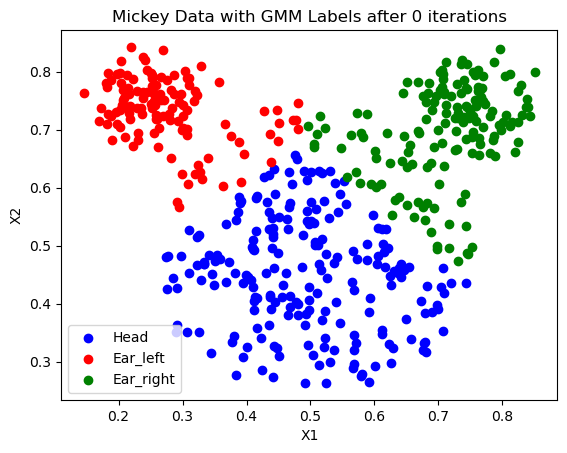

In [13]:
gmm_y_hat = np.array(list(map(lambda x : np.argmax(x), gamma)))

mickey_X_pred_head = mickey_X[gmm_y_hat == 1]
mickey_X_pred_ear_left = mickey_X[gmm_y_hat == 0]
mickey_X_pred_ear_right = mickey_X[gmm_y_hat == 2]

plt.figure()
plt.scatter(mickey_X_pred_head[:, 0], mickey_X_pred_head[:, 1], c='b')
plt.scatter(mickey_X_pred_ear_left[:, 0], mickey_X_pred_ear_left[:, 1], c='r')
plt.scatter(mickey_X_pred_ear_right[:, 0], mickey_X_pred_ear_right[:, 1], c='g')
plt.legend(["Head", "Ear_left", "Ear_right"])
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Mickey Data with GMM Labels after {curr_iter} iterations")
plt.savefig(f'gmm_mickey_{curr_iter}.png', bbox_inches='tight')
plt.show()

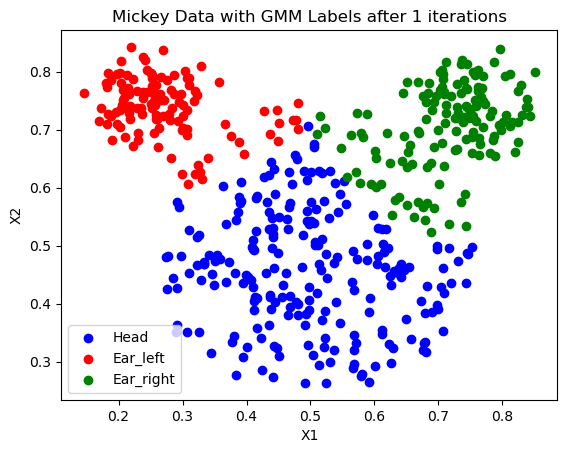

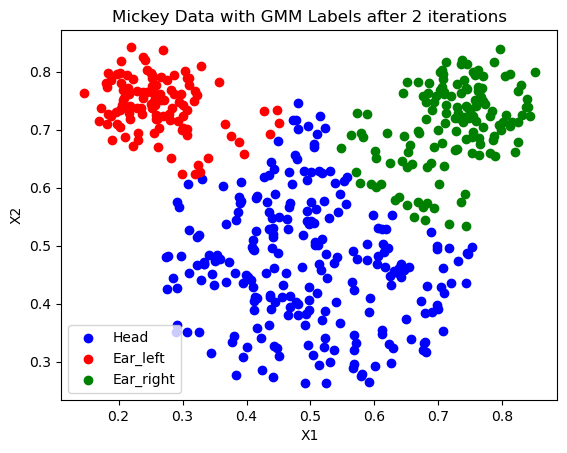

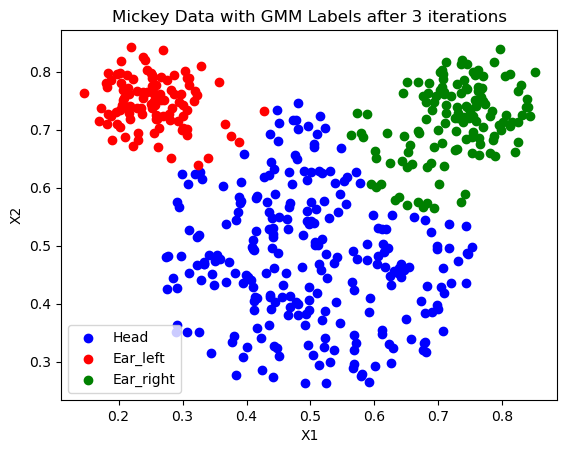

In [14]:
while (ll_diff >= CONVERGENCE_CRITERION) and (curr_iter < MAX_ITERATIONS):
    curr_iter += 1
    
    # E-Step
    for n in range(N):
        for k in range(K):
            gamma[n][k] = update_gamma_k(mickey_X[n], weights, mu, sigma, k)
            
    # M-Step
    for k in range(K):
        mu[k] = update_mu_k(mickey_X, gamma[:, k])
        sigma[k] = update_sigma_k(mickey_X, gamma[:, k], mu[k])
        weights[k] = update_weight_k(gamma[:, k], N)
    
    if (curr_iter < 4):
        gmm_y_hat = np.array(list(map(lambda x : np.argmax(x), gamma)))

        mickey_X_pred_head = mickey_X[gmm_y_hat == 1]
        mickey_X_pred_ear_left = mickey_X[gmm_y_hat == 0]
        mickey_X_pred_ear_right = mickey_X[gmm_y_hat == 2]
        
        plt.figure()
        plt.scatter(mickey_X_pred_head[:, 0], mickey_X_pred_head[:, 1], c='b')
        plt.scatter(mickey_X_pred_ear_left[:, 0], mickey_X_pred_ear_left[:, 1], c='r')
        plt.scatter(mickey_X_pred_ear_right[:, 0], mickey_X_pred_ear_right[:, 1], c='g')
        plt.legend(["Head", "Ear_left", "Ear_right"])
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title(f"Mickey Data with GMM Labels after {curr_iter} iterations")
        plt.savefig(f'gmm_mickey_{curr_iter}.png', bbox_inches='tight')
        plt.show()
    
    ll.append(get_log_likelihood(mickey_X, mu, sigma, weights))
    ll_diff = abs(ll[-1] - ll[-2])

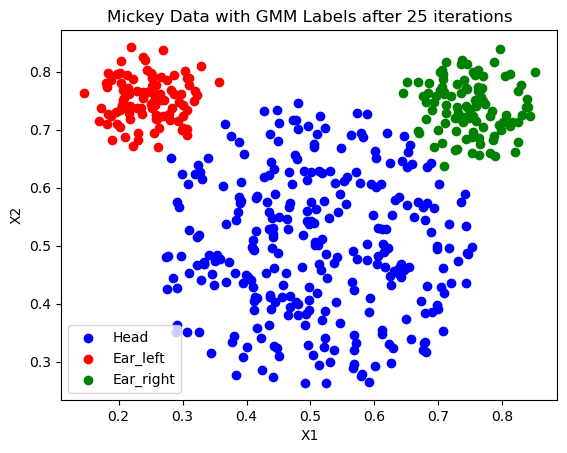

In [15]:
gmm_y_hat = np.array(list(map(lambda x : np.argmax(x), gamma)))

mickey_X_pred_head = mickey_X[gmm_y_hat == 1]
mickey_X_pred_ear_left = mickey_X[gmm_y_hat == 0]
mickey_X_pred_ear_right = mickey_X[gmm_y_hat == 2]

plt.figure()
plt.scatter(mickey_X_pred_head[:, 0], mickey_X_pred_head[:, 1], c='b')
plt.scatter(mickey_X_pred_ear_left[:, 0], mickey_X_pred_ear_left[:, 1], c='r')
plt.scatter(mickey_X_pred_ear_right[:, 0], mickey_X_pred_ear_right[:, 1], c='g')
plt.legend(["Head", "Ear_left", "Ear_right"])
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Mickey Data with GMM Labels after {curr_iter} iterations")
plt.savefig(f'gmm_mickey_convergence.png', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

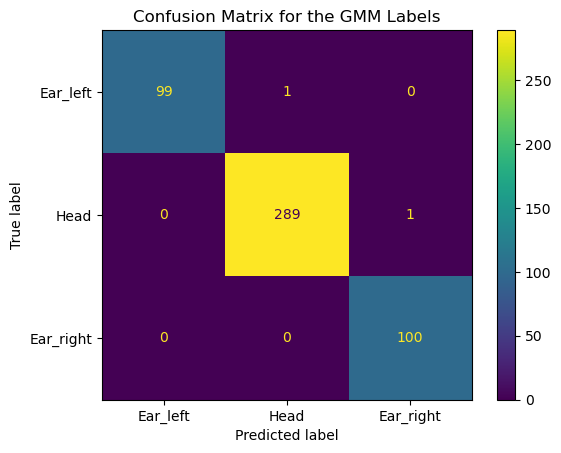

In [16]:
c_matrix_gmm = confusion_matrix(mickey_Y, gmm_y_hat)

plt.figure()
c_mat_disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix_gmm, display_labels=['Ear_left', 'Head', 'Ear_right'])
c_mat_disp.plot()
plt.title("Confusion Matrix for the GMM Labels")
plt.savefig('gmm_cmat.png', bbox_inches='tight')
plt.show()

In [17]:
f1_gmm = f1_score(mickey_Y, gmm_y_hat, average='weighted')
print(f"Weighted F-1 Score for GMM is {f1_gmm}")

Weighted F-1 Score for GMM is 0.995918316325255


In [18]:
print("For the same dataset, GMM has a higher Weighted F-1 Score than K-Means, we can safely say that GMM has performed better than K-Means.")

For the same dataset, GMM has a higher Weighted F-1 Score than K-Means, we can safely say that GMM has performed better than K-Means.
